## Hybrid Attempt (v6)

>>> INIZIO PIPELINE (Inflazione PCA + Tematico GT + Test Stazionarietà) <<<

--- Inizio Caricamento Dati ---
--- Fine Caricamento Dati (9 gruppi caricati) ---

--- Inizio Identificazione Periodo Comune ---
Info (Periodo Comune): Da 2004-01-01 a 2024-12-01
--- Fine Identificazione Periodo Comune ---

--- Inizio Combinazione Dati ---
Info (Combinazione): DF combinato 252r x 45c.
--- Fine Combinazione Dati ---

--- Inizio Pulizia Valori Google Trends ('<1') ---
--- Fine Pulizia Valori Google Trends --- 

--- Inizio Gestione NaN (Strategia: fillna) ---
Info: Nessun NaN trovato.
--- Inizio Standardizzazione Serie (Z-score) ---
--- Fine Standardizzazione Serie ---

--- Inizio Creazione Indice Inflazione PCA (keyword: 'inflazione') ---
Info: Varianza spiegata accettabile per indice inflazione (99.15%)
  Loadings indice inflazione:
    Termini_Diretti_inflazione: (italia): 0.3278
    Alimentari_inflazione: (italia): 0.3340
    Energia_inflazione: (italia): 0.3334
    Abitazione_inflazione: (it

/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_66023/3009485833.py:370: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_ct = kpss(timeseries_clean, regression='ct', nlags="auto")
/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_66023/3009485833.py:357: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test_c = kpss(timeseries_clean, regression='c', nlags="auto")
/var/folders/3m/15k2tqw90_s76rn9_8yw2p3r0000gn/T/ipykernel_66023/3009485833.py:370: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test_ct = kpss(timeseries_clean, regression='ct', nlags="auto")


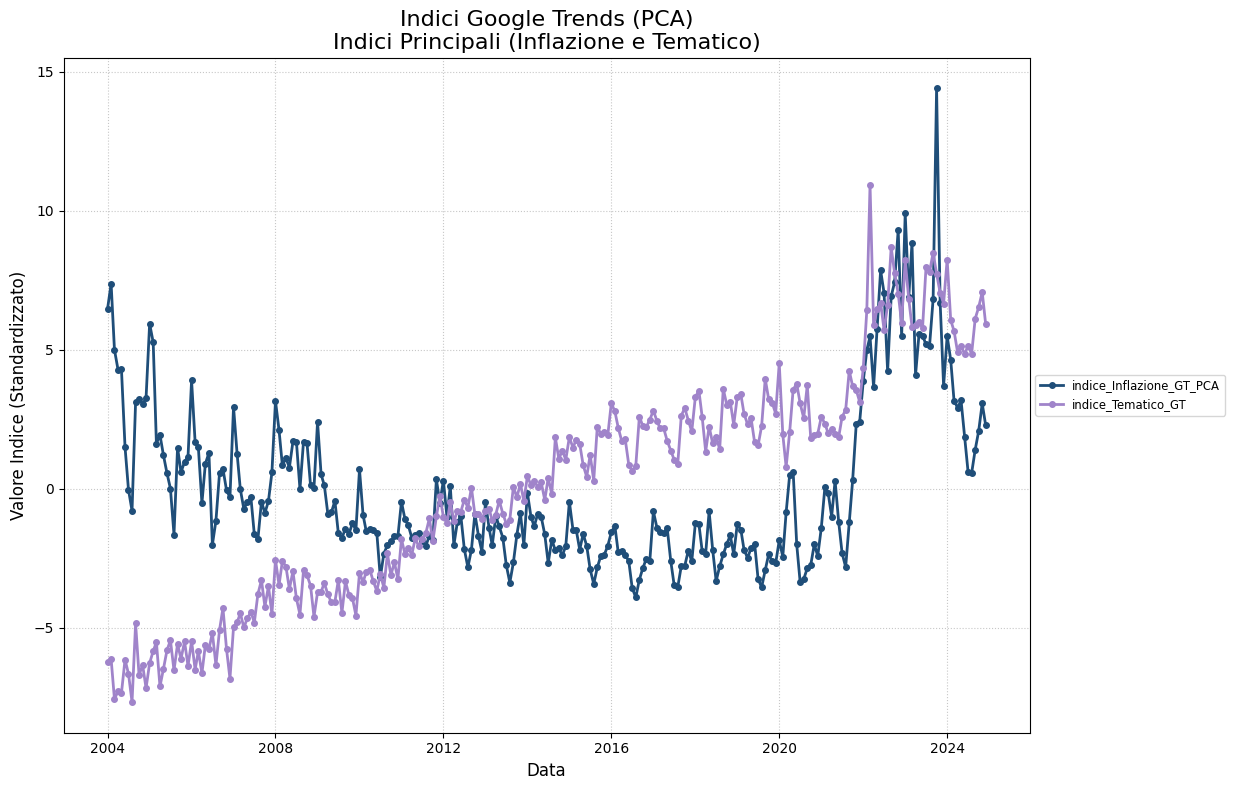

Info: Indici salvati con successo in '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests.csv'
--- Fine Visualizzazione e Salvataggio Indici (Grafici di Base) ---

--- Inizio Creazione Grafici Analisi Dettagliata ---
Grafico varianza spiegata gruppi salvato in /Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests_varianza_spiegata_gruppi.png


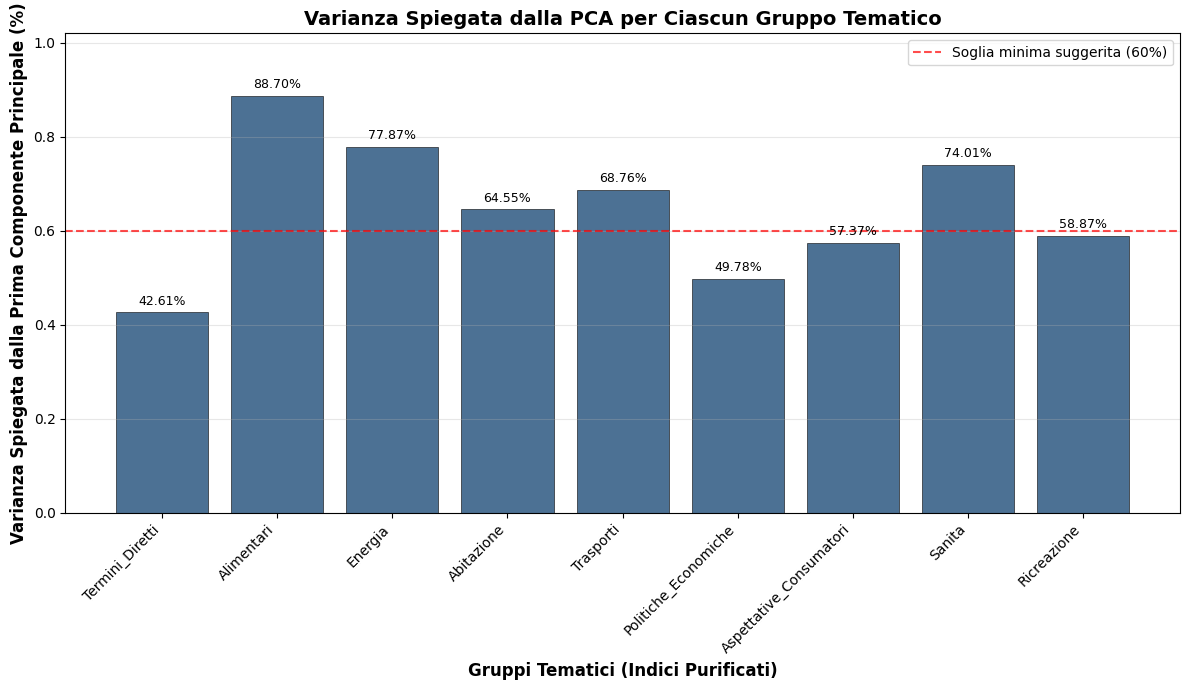

Grafico correlazione indici principali salvato in /Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests_correlazione_indici_principali.png


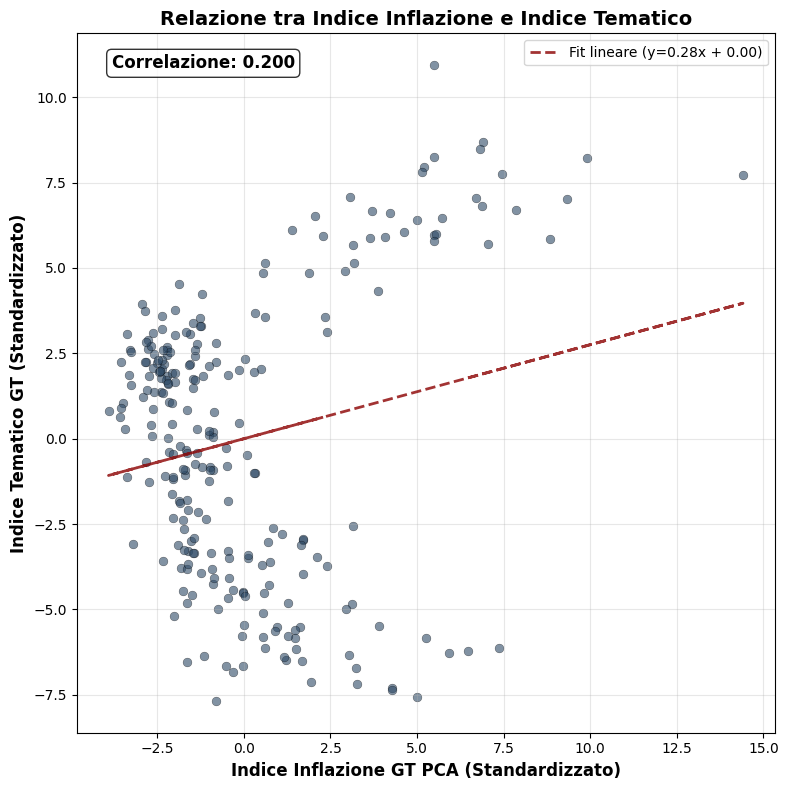

Grafico evoluzione indice inflazione salvato in /Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests_evoluzione_indice_inflazione.png


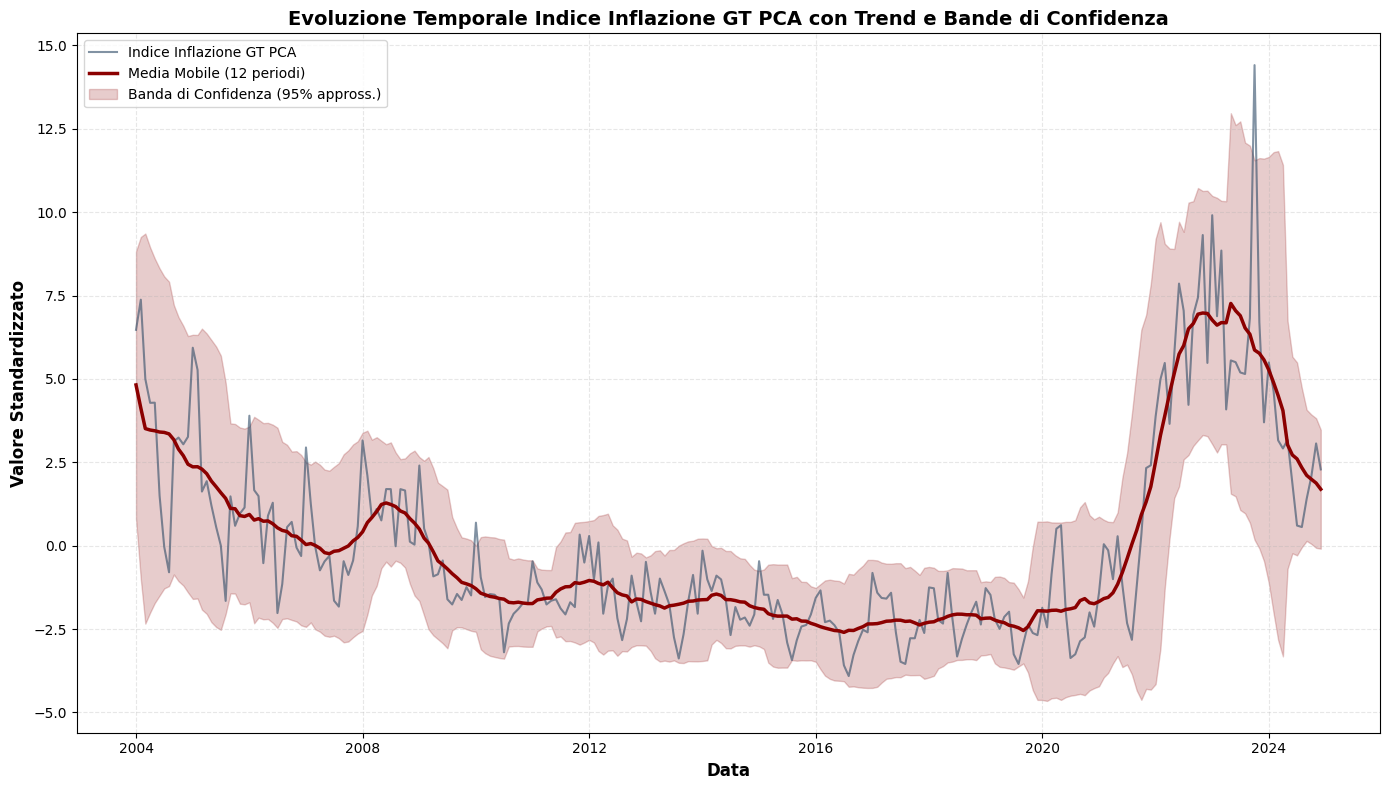

Grafico evoluzione indice tematico salvato in /Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests_evoluzione_indice_tematico.png


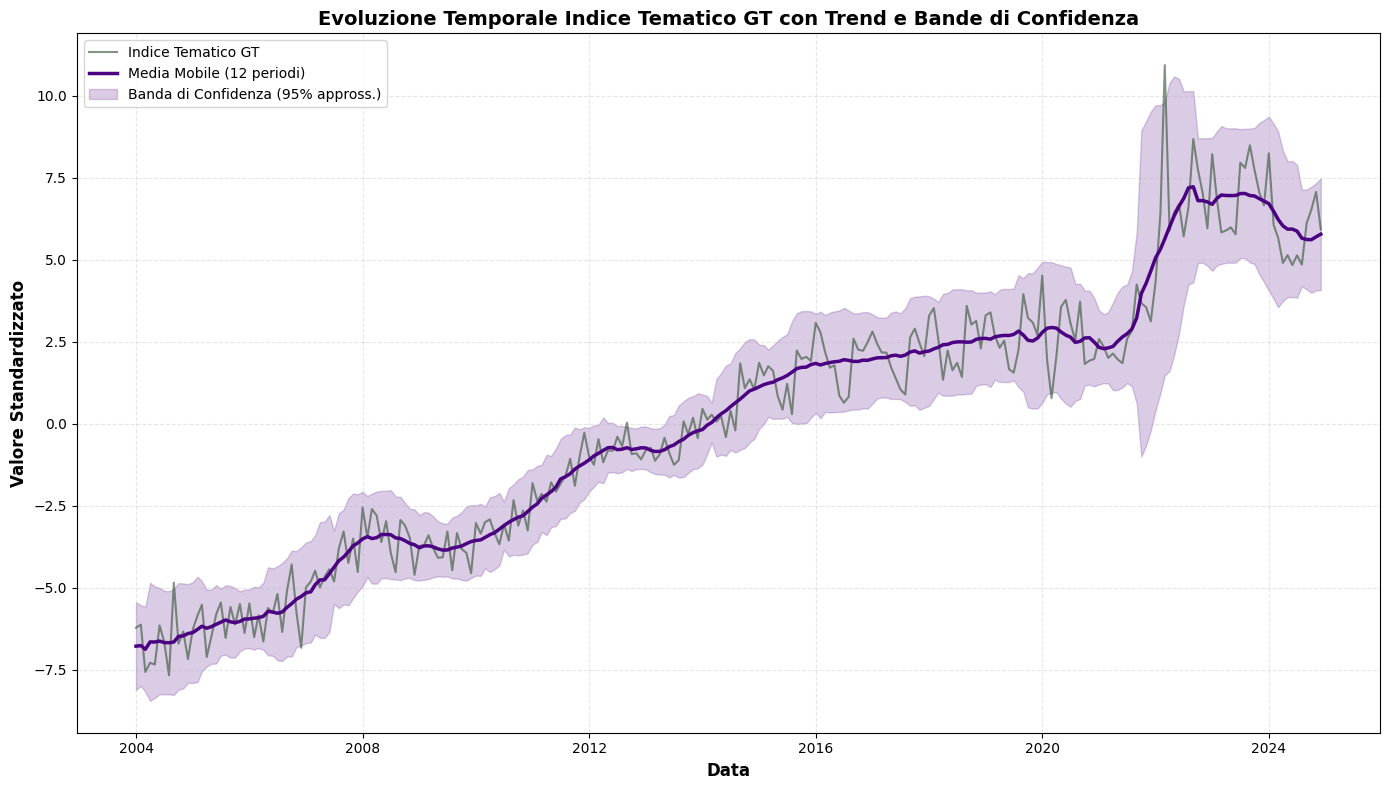

--- Fine Creazione Grafici Analisi Dettagliata ---


>>> PIPELINE HYBRID INDEXES COMPLETATA <<<


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller, kpss # Test di stazionarietà

# --- CONFIGURAZIONE ---
PATH_DATI = "/Users/tommaso/Desktop/tesi-inflation-gt/Official_4"
PATH_SALVATAGGIO_INDICI = '/Users/tommaso/Desktop/tesi-inflation-gt/PCA/indici_gt_hybrid_v6_tests.csv'
# Definisco un percorso aggiuntivo per i grafici dettagliati, derivandolo da PATH_SALVATAGGIO_INDICI
PATH_BASE_SALVATAGGIO_GRAFICI_DETTAGLIATI = os.path.splitext(PATH_SALVATAGGIO_INDICI)[0]


NOMI_GRUPPI_DICT = {
    "Gruppo1(4)": "Termini_Diretti",
    "Gruppo2(4)": "Alimentari",
    "Gruppo3(4)": "Energia",
    "Gruppo4(4)": "Abitazione",
    "Gruppo5(4)": "Trasporti",
    "Gruppo6(4)": "Politiche_Economiche",
    "Gruppo7(4)": "Aspettative_Consumatori",
    "Gruppo8(4)": "Sanita",
    "Gruppo9(4)": "Ricreazione",
}
# Parola chiave per identificare le colonne relative all'inflazione diretta
INFLATION_KEYWORD_IN_COLNAME = "inflazione"
# Livelli di significatività per i test di stazionarietà
SIGNIFICANCE_LEVEL = 0.05

# --- 1. CARICAMENTO DATI ---
def carica_dati_gt(path_csv, nomi_file_mappati):
    dati_caricati_per_gruppo = {}
    print("--- Inizio Caricamento Dati ---")
    for nome_file_csv, nome_gruppo_logico in nomi_file_mappati.items():
        file_path = os.path.join(path_csv, f"{nome_file_csv}.csv")
        try:
            df = pd.read_csv(file_path, skiprows=2, header=0) # Salto le prime due righe del csv per conformazione propria dello stesso
            df.columns = [str(col).strip().lower() for col in df.columns] # Nomi colonne lowercase e puliti
            # Logica robusta per trovare la colonna data (mese, settimana, giorno)
            colonna_data = None
            for possible_date_col in ['mese', 'month', 'settimana', 'week', 'giorno', 'day']:
                if possible_date_col in df.columns:
                    colonna_data = possible_date_col
                    break
            if colonna_data is None:
                raise ValueError(f"Nessuna colonna data standard ('mese', 'month', 'settimana', 'week', 'giorno', 'day') trovata in {nome_file_csv}")
            if colonna_data != 'mese': # Info se non è 'mese'
                print(f"Info: Trovata colonna data '{colonna_data}' in {nome_file_csv}.")

            df.set_index(colonna_data, inplace=True)
            try: # Provo a convertire l'indice in datetime (formato standard)
                df.index = pd.to_datetime(df.index)
            except Exception: # Fallback per formati non standard come YYYY-MM
                df.index = pd.to_datetime(df.index, format="%Y-%m") # Adatto forzatamente il formato, se necessario
            dati_caricati_per_gruppo[nome_gruppo_logico] = df
        except Exception as e:
            print(f"ERRORE nel caricamento di '{nome_file_csv}.csv': {e}")
    print(f"--- Fine Caricamento Dati ({len(dati_caricati_per_gruppo)} gruppi caricati) ---\n")
    return dati_caricati_per_gruppo

# --- 2. IDENTIFICAZIONE PERIODO COMUNE ---
def trova_periodo_comune(dati_dict_input):
    print("--- Inizio Identificazione Periodo Comune ---")
    if not dati_dict_input: return None, None
    date_inizio_valide, date_fine_valide = [], []
    for df in dati_dict_input.values():
        if not df.empty and isinstance(df.index, pd.DatetimeIndex):
            date_inizio_valide.append(df.index.min())
            date_fine_valide.append(df.index.max())
    if not date_inizio_valide: return None, None
    inizio_comune_calc, fine_comune_calc = max(date_inizio_valide), min(date_fine_valide)
    if inizio_comune_calc > fine_comune_calc: # Controllo se il periodo comune è valido
        print(f"Attenzione: Nessun periodo comune valido. Inizio calcolato ({inizio_comune_calc}) > Fine calcolata ({fine_comune_calc}).")
        return None, None
    print(f"Info (Periodo Comune): Da {inizio_comune_calc.strftime('%Y-%m-%d')} a {fine_comune_calc.strftime('%Y-%m-%d')}")
    print("--- Fine Identificazione Periodo Comune ---\n")
    return inizio_comune_calc, fine_comune_calc

# --- 3. COMBINAZIONE DATI SU PERIODO COMUNE ---
def combina_dati_su_periodo_comune(dati_dict_input, inizio_dt, fine_dt):
    print("--- Inizio Combinazione Dati ---")
    if inizio_dt is None or fine_dt is None or not dati_dict_input: return None
    # Creo un indice temporale mensile per il periodo comune
    idx_comune = pd.date_range(start=inizio_dt, end=fine_dt, freq='MS') # 'MS' per inizio mese
    df_combinato_finale = pd.DataFrame(index=idx_comune)

    for nome_gruppo_logico, df_originale in dati_dict_input.items():
        if df_originale.empty or not isinstance(df_originale.index, pd.DatetimeIndex): continue
        # Filtro il DataFrame del gruppo per il periodo comune
        df_periodo_gruppo = df_originale[(df_originale.index >= inizio_dt) & (df_originale.index <= fine_dt)]
        if df_periodo_gruppo.empty: continue

        for col_originale_nome in df_periodo_gruppo.columns:
            # Aggiungo prefisso del gruppo al nome della colonna per evitare duplicati
            nome_colonna_con_prefisso = f"{nome_gruppo_logico}_{col_originale_nome}"
            # Riempio il DataFrame combinato, facendo reindex per allineare le date
            df_combinato_finale[nome_colonna_con_prefisso] = df_periodo_gruppo[col_originale_nome].reindex(df_combinato_finale.index)
    print(f"Info (Combinazione): DF combinato {df_combinato_finale.shape[0]}r x {df_combinato_finale.shape[1]}c.")
    print("--- Fine Combinazione Dati ---\n")
    return df_combinato_finale

# --- 4. PULIZIA VALORI GOOGLE TRENDS ('<1') ---
def pulisci_valori_gt(df_input):
    print("--- Inizio Pulizia Valori Google Trends ('<1') ---")
    if df_input is None: return None
    df_pulito = df_input.copy()
    for col in df_pulito.columns:
        # Controllo se la colonna contiene il pattern '<1' o '< 1'
        col_as_str = df_pulito[col].astype(str) # Converti in stringa per il check
        if col_as_str.str.contains(r'< ?1').any(): # Regex per '<1' o '< 1'
            # Sostituisco '<1' o '< 1' con 0.5
            df_pulito[col] = df_pulito[col].replace(to_replace=r'< ?1', value=0.5, regex=True)
        # Riconverto la colonna a numerico, eventuali errori diventano NaN (gestiti subito dopo)
        df_pulito[col] = pd.to_numeric(df_pulito[col], errors='coerce')
    print("--- Fine Pulizia Valori Google Trends --- \n")
    return df_pulito

# --- 5. GESTIONE VALORI MANCANTI (NaN) ---
def gestisci_nan(df_input, strategy='fillna', fill_value=0, interpolate_method='linear'):
    print(f"--- Inizio Gestione NaN (Strategia: {strategy}) ---")
    if df_input is None: return None
    df_gestito = df_input.copy()
    if not df_gestito.isnull().values.any(): # Se non ci sono NaN, ritorna il df
        print("Info: Nessun NaN trovato.")
        return df_gestito

    if strategy == 'fillna': # "fillna" riempie i NaN con un valore fisso
        df_gestito = df_gestito.fillna(fill_value)
    elif strategy == 'interpolate': # Interpolo i NaN
        df_gestito = df_gestito.interpolate(method=interpolate_method, axis=0)
        # Se rimangono NaN dopo l'interpolazione li riempio di nuovo
        if df_gestito.isnull().values.any():
            df_gestito = df_gestito.fillna(fill_value) # Fallback
    # Se non dovesse funzionare, qua posso usare altre strategie come 'dropna'
    print("Info: NaN gestiti.")
    print("--- Fine Gestione NaN ---\n")
    return df_gestito

# --- 6. STANDARDIZZAZIONE SERIE (Z-SCORE) ---
def standardizza_serie_temporali(df_input):
    print("--- Inizio Standardizzazione Serie (Z-score) ---")
    if df_input is None: return None
    df_std = df_input.copy()
    for col in df_std.columns:
        if not pd.api.types.is_numeric_dtype(df_std[col]): continue # Salto colonne non numeriche
        media = df_std[col].mean()
        std_dev = df_std[col].std()
        # Evito divisione per zero se la deviazione standard è nulla
        if std_dev > 1e-9: # Soglia minima per evitare instabilità
            df_std[col] = (df_std[col] - media) / std_dev
        else:
            df_std[col] = 0 # Se std è zero, la serie è costante, z-score è 0
    print("--- Fine Standardizzazione Serie ---\n")
    return df_std

# --- 7. CREAZIONE INDICE INFLAZIONE TRAMITE PCA E SEPARAZIONE TERMINI ---
def crea_indice_inflazione_pca_e_separa_termini(df_std_input, inflation_keyword):
    print(f"--- Inizio Creazione Indice Inflazione PCA (keyword: '{inflation_keyword}') ---")
    if df_std_input is None or df_std_input.empty:
        return pd.Series(dtype=float), df_std_input # Ritorna serie vuota e df originale

    # Identifico colonne relative all'inflazione
    colonne_inflazione = [col for col in df_std_input.columns if inflation_keyword.lower() in col.lower()]
    indice_inflazione_pca_series = pd.Series(index=df_std_input.index, dtype=float) # Inizializza serie vuota
    df_senza_termini_inflazione = df_std_input.copy() # Inizialmente, df senza termini inflazione è una copia

    if not colonne_inflazione:
        print(f"Attenzione: Nessun termine contenente '{inflation_keyword}' trovato nelle colonne del DataFrame.")
    else:
        # Seleziono solo le colonne di inflazione e quelle con varianza > 0 (o una soglia molto piccola)
        df_termini_inflazione_validi = df_std_input[colonne_inflazione].loc[:, df_std_input[colonne_inflazione].var(skipna=True) > 1e-9]

        if df_termini_inflazione_validi.empty:
            print(f"Attenzione: Nessun termine di inflazione con varianza sufficiente trovato per PCA.")
        elif df_termini_inflazione_validi.shape[1] == 1: # Se c'è solo una colonna valida
            indice_inflazione_pca_series = df_termini_inflazione_validi.iloc[:, 0]
            print(f"Info: Usata singola colonna valida per Indice Inflazione: {df_termini_inflazione_validi.columns[0]}")
        else:
            pca_infl = PCA(n_components=1) # PCA con 1 componente
            try:
                if df_termini_inflazione_validi.isnull().values.any():
                    raise ValueError("Dati per PCA dell'indice inflazione contengono NaN. Gestire i NaN prima della PCA.")
                componente_infl = pca_infl.fit_transform(df_termini_inflazione_validi)

                # Validazione della varianza spiegata per l'indice inflazione
                if pca_infl.explained_variance_ratio_[0] < 0.6:
                    print(f"Attenzione: Varianza spiegata bassa per indice inflazione ({pca_infl.explained_variance_ratio_[0]:.2%})")
                else:
                    print(f"Info: Varianza spiegata accettabile per indice inflazione ({pca_infl.explained_variance_ratio_[0]:.2%})")

                # Interpretazione economica dei loadings per l'indice inflazione
                print(f"  Loadings indice inflazione:")
                for var_name, loading in zip(df_termini_inflazione_validi.columns, pca_infl.components_[0]):
                    print(f"    {var_name}: {loading:.4f}")

                indice_inflazione_pca_series = pd.Series(componente_infl.flatten(), index=df_termini_inflazione_validi.index)
            except Exception as e:
                print(f"ERRORE durante la PCA per l'Indice Inflazione: {e}")

        # Rimuovo le colonne di inflazione originali dal DataFrame per i passaggi successivi
        df_senza_termini_inflazione = df_std_input.drop(columns=colonne_inflazione, errors='ignore')

    print("--- Fine Creazione Indice Inflazione PCA ---\n")
    return indice_inflazione_pca_series, df_senza_termini_inflazione

# --- 8. CREAZIONE INDICI PCA PER GRUPPO (PURIFICATI) ---
def crea_indici_pca_per_gruppo_purificati(df_input_senza_infl, nomi_gruppi_mappati):
    print("--- Inizio Creazione Indici PCA per Gruppo (Purificati) ---")
    if df_input_senza_infl is None or df_input_senza_infl.empty:
        return pd.DataFrame(index=df_input_senza_infl.index if df_input_senza_infl is not None else None), {}

    indici_pca_df = pd.DataFrame(index=df_input_senza_infl.index)
    explained_variances_map = {} # Dizionario per salvare le varianze spiegate

    for nome_gruppo_logico in nomi_gruppi_mappati.values():
        # Seleziono colonne per il gruppo corrente (escludendo quelle di inflazione già trattate)
        colonne_del_gruppo = [col for col in df_input_senza_infl.columns if col.startswith(f"{nome_gruppo_logico}_")]
        nome_indice = f'indice_{nome_gruppo_logico}_Purificato'

        if not colonne_del_gruppo:
            indici_pca_df[nome_indice] = np.nan # Nessuna colonna per questo gruppo
            continue

        # Seleziono solo dati con varianza > 0 per PCA
        dati_gruppo_pca_validi = df_input_senza_infl[colonne_del_gruppo].loc[:, df_input_senza_infl[colonne_del_gruppo].var(skipna=True) > 1e-9]

        if dati_gruppo_pca_validi.shape[1] >= 1: # Almeno una colonna valida
            if dati_gruppo_pca_validi.shape[1] == 1: # Se c'è solo una colonna, la uso direttamente
                indici_pca_df[nome_indice] = dati_gruppo_pca_validi.iloc[:, 0]
                # Non calcolo la varianza spiegata da PCA se c'è una sola variabile
                print(f"Gruppo '{nome_gruppo_logico}' (Purificato): Usata singola colonna valida: {dati_gruppo_pca_validi.columns[0]}")
            else: # Più colonne, esegui PCA
                pca = PCA(n_components=1)
                try:
                    if dati_gruppo_pca_validi.isnull().values.any():
                        raise ValueError(f"Dati per PCA del gruppo '{nome_gruppo_logico}' contengono NaN.")
                    componente = pca.fit_transform(dati_gruppo_pca_validi)

                    # Validazione della varianza spiegata per il gruppo
                    current_explained_variance = pca.explained_variance_ratio_[0]
                    explained_variances_map[nome_indice] = current_explained_variance # Salvo varianza reale
                    if current_explained_variance < 0.6:
                        print(f"Attenzione: Varianza spiegata bassa per gruppo '{nome_gruppo_logico}' ({current_explained_variance:.2%})")
                    else:
                        print(f"Info: Varianza spiegata accettabile per gruppo '{nome_gruppo_logico}' ({current_explained_variance:.2%})")


                    # Interpretazione economica dei loadings per il gruppo
                    print(f"  Loadings gruppo '{nome_gruppo_logico}':")
                    for var_name, loading in zip(dati_gruppo_pca_validi.columns, pca.components_[0]):
                        print(f"    {var_name}: {loading:.4f}")

                    indici_pca_df[nome_indice] = componente.flatten()
                except Exception as e:
                    print(f"ERRORE PCA grp '{nome_gruppo_logico}': {e}")
                    indici_pca_df[nome_indice] = np.nan
        else: # Nessuna colonna con varianza sufficiente
            print(f"Gruppo '{nome_gruppo_logico}' (Purificato): Nessuna variabile con varianza sufficiente per PCA.")
            indici_pca_df[nome_indice] = np.nan

    print("--- Fine Creazione Indici PCA per Gruppo (Purificati) ---\n")
    return indici_pca_df, explained_variances_map

# --- 9. CREAZIONE INDICE TEMATICO GT (PCA SU INDICI DI GRUPPO PURIFICATI) ---
def crea_indice_tematico_gt(df_indici_gruppo_puri_input):
    print("--- Inizio Creazione Indice Tematico GT ---")
    nome_indice_output = 'indice_Tematico_GT'
    if df_indici_gruppo_puri_input is None or df_indici_gruppo_puri_input.empty:
        return pd.Series(dtype=float, index=df_indici_gruppo_puri_input.index if df_indici_gruppo_puri_input is not None else None)

    # Rimuovo colonne che sono interamente NaN, poi righe che hanno ALMENO un NaN tra gli indici rimanenti
    df_per_pca_tematica = df_indici_gruppo_puri_input.dropna(axis=1, how='all').dropna(axis=0, how='any')
    serie_indice_tematico_gt = pd.Series(index=df_indici_gruppo_puri_input.index, dtype=float) # Inizializzo serie vuota

    if df_per_pca_tematica.empty:
        print("Attenzione: Nessuna riga/colonna valida dopo rimozione NaN dagli indici di gruppo. Indice Tematico non creato.")
        return serie_indice_tematico_gt

    # Seleziono solo indici tematici con varianza > 0
    indici_tematici_validi = df_per_pca_tematica.loc[:, df_per_pca_tematica.var(skipna=True) > 1e-9]

    if indici_tematici_validi.shape[1] >= 1: # Almeno un indice di gruppo valido
        if indici_tematici_validi.shape[1] == 1: # Se c'è solo un indice di gruppo valido, lo uso direttamente
            print(f"Info: Un solo indice di gruppo purificato valido ('{indici_tematici_validi.columns[0]}'). Usato come Indice Tematico GT.")
            serie_indice_tematico_gt = indici_tematici_validi.iloc[:,0].reindex(df_indici_gruppo_puri_input.index) # Reindex per mantenere l'indice originale
        else: # Più indici di gruppo, esegui PCA
            pca_tematico = PCA(n_components=1)
            try:
                # Non dovrebbe esserci NaN qui grazie al .dropna() sopra, ma un check in più non ha mai ucciso nessuno
                if indici_tematici_validi.isnull().values.any():
                     raise ValueError("Dati per PCA dell'Indice Tematico contengono NaN inattesi.")
                componente_tematico = pca_tematico.fit_transform(indici_tematici_validi)
                temp_serie = pd.Series(componente_tematico.flatten(), index=indici_tematici_validi.index)

                # Validazione della varianza spiegata per l'indice tematico
                if pca_tematico.explained_variance_ratio_[0] < 0.6:
                    print(f"Attenzione: Varianza spiegata bassa per indice tematico ({pca_tematico.explained_variance_ratio_[0]:.2%})")
                else:
                    print(f"Info: Varianza spiegata accettabile per indice tematico ({pca_tematico.explained_variance_ratio_[0]:.2%})")

                serie_indice_tematico_gt = temp_serie.reindex(df_indici_gruppo_puri_input.index) # Reindex all'indice originale completo
                # Il print originale è stato integrato sopra e nei loadings
                print(f"  Loadings su {nome_indice_output}:")
                [print(f"    {n}: {l:.4f}") for n,l in zip(indici_tematici_validi.columns, pca_tematico.components_[0])]
            except Exception as e:
                print(f"ERRORE PCA Indice Tematico: {e}")
    else:
        print("Info: Nessun indice di gruppo purificato con varianza sufficiente trovato per creare l'Indice Tematico GT.")

    print("--- Fine Creazione Indice Tematico GT ---\n")
    return serie_indice_tematico_gt

# --- 10. TEST DI STAZIONARIETÀ (ADF E KPSS) ---
def test_stazionarieta(timeseries, series_name="Serie", significance_level=0.05):
    """
    Esegue i test ADF e KPSS su una serie temporale e stampa i risultati.
    """
    print(f"--- Test di Stazionarietà per: {series_name} ---")
    timeseries_clean = timeseries.dropna() # Rimuovo NaN solo per i test

    if timeseries_clean.empty:
        print("Serie vuota dopo rimozione NaN. Impossibile testare.")
        return
    if len(timeseries_clean) < 4 : # Controllo se la serie è troppo corta (molti test esigono un numero minimo di osservazioni)
        print(f"Serie '{series_name}' troppo corta ({len(timeseries_clean)} punti) per test di stazionarietà affidabili.")
        return

    # Test ADF (Augmented Dickey-Fuller)
    # Ipotesi Nulla (H0): La serie ha una radice unitaria (non è stazionaria).
    # Ipotesi Alternativa (H1): La serie non ha una radice unitaria (è stazionaria).
    # Se p-value < significance_level => Rifiuto H0 => Stazionaria
    print("-> Test ADF:")
    try:
        adf_test = adfuller(timeseries_clean, autolag='AIC')
        adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
        for key,value in adf_test[4].items():
            adf_output['Critical Value (%s)'%key] = value
        print(adf_output)
        if adf_test[1] <= significance_level:
            print(f"Risultato ADF: La serie '{series_name}' è probabilmente STAZIONARIA (p-value={adf_test[1]:.3f} <= {significance_level}).")
        else:
            print(f"Risultato ADF: La serie '{series_name}' è probabilmente NON STAZIONARIA (p-value={adf_test[1]:.3f} > {significance_level}).")
    except Exception as e: # Gestione più specifica di errori comuni per ADF
        print(f"ERRORE durante il test ADF per '{series_name}': {e}")
        if "maxlag must be less than..." in str(e) or "data are essentially constant" in str(e):
             print("Info: La serie potrebbe essere troppo corta o costante per il test ADF con autolag.")


    print("\n-> Test KPSS (Kwiatkowski-Phillips-Schmidt-Shin):")
    # Ipotesi Nulla (H0): La serie è stazionaria attorno a una media o a un trend deterministico.
    # Ipotesi Alternativa (H1): La serie ha una radice unitaria (non è stazionaria).
    # Se statistica test > valore critico => Rifiuto H0 => Non Stazionaria (intorno a quel livello/trend)
    # Se p-value < significance_level => Rifiuto H0 => Non Stazionaria (interpretazione comune del p-value, anche se per KPSS è un po' diverso)
    try:
        # Testo per stazionarietà attorno a una costante ('c')
        kpss_test_c = kpss(timeseries_clean, regression='c', nlags="auto")
        kpss_output_c = pd.Series(kpss_test_c[0:3], index=['Test Statistic','p-value','Lags Used'])
        # Nota: il p-value di KPSS ha limiti (es. > 0.1 o < 0.01). Interpretare con cautela.
        print("KPSS (regression='c' - Stazionarietà attorno a costante):")
        print(kpss_output_c)
        # L'interpretazione del p-value di statsmodels.kpss è:
        # H0: stazionaria. Se p-value < alpha, rifiutiamo H0.
        if kpss_test_c[1] >= significance_level: # Non rifiuto H0
             print(f"Risultato KPSS ('c'): NON si rifiuta H0. La serie '{series_name}' è probabilmente STAZIONARIA attorno a una costante (p-value={kpss_test_c[1]:.3f} >= {significance_level}).")
        else: # Rifiuto H0
             print(f"Risultato KPSS ('c'): Si rifiuta H0. La serie '{series_name}' è probabilmente NON STAZIONARIA attorno a una costante (p-value={kpss_test_c[1]:.3f} < {significance_level}).")

        # Testo anche per stazionarietà attorno a un trend ('ct')
        kpss_test_ct = kpss(timeseries_clean, regression='ct', nlags="auto")
        kpss_output_ct = pd.Series(kpss_test_ct[0:3], index=['Test Statistic','p-value','Lags Used'])
        print("\nKPSS (regression='ct' - Stazionarietà attorno a trend):")
        print(kpss_output_ct)
        if kpss_test_ct[1] >= significance_level: # Non rifiuto H0
             print(f"Risultato KPSS ('ct'): NON si rifiuta H0. La serie '{series_name}' è probabilmente STAZIONARIA attorno a un trend (p-value={kpss_test_ct[1]:.3f} >= {significance_level}).")
        else: # Rifiuto H0
             print(f"Risultato KPSS ('ct'): Si rifiuta H0. La serie '{series_name}' è probabilmente NON STAZIONARIA attorno a un trend (p-value={kpss_test_ct[1]:.3f} < {significance_level}).")
    except Exception as e:
        print(f"ERRORE durante il test KPSS per '{series_name}': {e}")
        if "The Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test is not suitable for series with less than 4 data points" in str(e):
            print("Info: La serie potrebbe essere troppo corta per il test KPSS.") # Già gestito sopra, ma ridondanza non nuoce

    print("--- Fine Test Stazionarietà ---\n")


# --- FUNZIONE PER GRAFICI DI ANALISI DETTAGLIATA ---
def crea_grafici_analisi_dettagliata(df_indici, df_standardizzato_non_usato, path_salvataggio_base, varianze_spiegate_gruppi_reali):
    """
    Creo grafici di analisi dettagliata per l'elaborato finale.
    df_standardizzato_non_usato: attualmente non utilizzato in questa funzione, ma mantenuto per coerenza con la richiesta.
    varianze_spiegate_gruppi_reali: dizionario {nome_indice_gruppo: varianza_spiegata}
    """
    print("--- Inizio Creazione Grafici Analisi Dettagliata ---")
    # Mi assicuro che la directory di salvataggio esista
    os.makedirs(os.path.dirname(path_salvataggio_base), exist_ok=True)

    # Configurazione stile grafici coerente
    plt.rcParams.update({
        'figure.facecolor': 'white',
        'axes.facecolor': 'white',
        'axes.edgecolor': 'black',
        'axes.linewidth': 0.8,
        'xtick.color': 'black',
        'ytick.color': 'black',
        'text.color': 'black'
    })

    # Palette colori limitata e coerente
    colori_principali = ['#2E4A66', '#8B0000', '#2F4F2F', '#4B0082', '#B8860B']

    # 1. Grafico distribuzione varianza spiegata per gruppo
    if varianze_spiegate_gruppi_reali: # Se il dizionario non è vuoto
        plt.figure(figsize=(12, 7)) # Aumentato leggermente per poter leggere bene i nomi lunghi
        
        nomi_gruppi_plot = [name.replace('indice_', '').replace('_Purificato', '') for name in varianze_spiegate_gruppi_reali.keys()]
        valori_varianze_plot = list(varianze_spiegate_gruppi_reali.values())

        # Unico colore blu elegante
        colore_blu_elegante = '#1f4e79'
        bars = plt.bar(range(len(nomi_gruppi_plot)), valori_varianze_plot, color=colore_blu_elegante, alpha=0.8, edgecolor='black', linewidth=0.5)
        for bar in bars: # Aggiungo etichetta valore su ogni barra
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom', fontsize=9)

        plt.axhline(y=0.6, color='red', linestyle='--', alpha=0.7, label='Soglia minima suggerita (60%)')
        plt.xlabel('Gruppi Tematici (Indici Purificati)', fontsize=12, fontweight='bold')
        plt.ylabel('Varianza Spiegata dalla Prima Componente Principale (%)', fontsize=12, fontweight='bold')
        plt.title('Varianza Spiegata dalla PCA per Ciascun Gruppo Tematico', fontsize=14, fontweight='bold')
        plt.xticks(range(len(nomi_gruppi_plot)), nomi_gruppi_plot, rotation=45, ha='right', fontsize=10)
        plt.legend()
        plt.grid(True, alpha=0.3, axis='y')
        plt.ylim(0, max(valori_varianze_plot) * 1.15 if valori_varianze_plot else 1) # Adatto l'asse Y
        plt.tight_layout()
        try:
            plt.savefig(f"{path_salvataggio_base}_varianza_spiegata_gruppi.png", dpi=300, bbox_inches='tight')
            print(f"Grafico varianza spiegata gruppi salvato in {path_salvataggio_base}_varianza_spiegata_gruppi.png")
        except Exception as e:
            print(f"Errore nel salvataggio del grafico varianza spiegata gruppi: {e}")
        plt.show()
    else:
        print("Nessuna varianza spiegata da PCA di gruppo disponibile per il grafico.")


    # 2. Grafico correlazione tra indici principali
    if 'indice_Inflazione_GT_PCA' in df_indici.columns and 'indice_Tematico_GT' in df_indici.columns:
        plt.figure(figsize=(8, 8))
        x_vals = df_indici['indice_Inflazione_GT_PCA'].dropna()
        y_vals = df_indici['indice_Tematico_GT'].dropna()
        common_idx = x_vals.index.intersection(y_vals.index)

        if len(common_idx) > 1: # Necessari almeno 2 punti per polyfit e correlazione significativa
            x_common = x_vals[common_idx]
            y_common = y_vals[common_idx]

            plt.scatter(x_common, y_common, alpha=0.6, color=colori_principali[0], s=40, edgecolors='black', linewidth=0.3)

            # Aggiungo linea di regressione
            z = np.polyfit(x_common, y_common, 1)
            p = np.poly1d(z)
            plt.plot(x_common, p(x_common), color=colori_principali[1], linestyle='--', linewidth=2, alpha=0.8, label=f'Fit lineare (y={z[0]:.2f}x + {z[1]:.2f})')

            correlazione = np.corrcoef(x_common, y_common)[0,1]
            plt.text(0.05, 0.95, f'Correlazione: {correlazione:.3f}', transform=plt.gca().transAxes,
                     fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

            plt.xlabel('Indice Inflazione GT PCA (Standardizzato)', fontsize=12, fontweight='bold')
            plt.ylabel('Indice Tematico GT (Standardizzato)', fontsize=12, fontweight='bold')
            plt.title('Relazione tra Indice Inflazione e Indice Tematico', fontsize=14, fontweight='bold')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            try:
                plt.savefig(f"{path_salvataggio_base}_correlazione_indici_principali.png", dpi=300, bbox_inches='tight')
                print(f"Grafico correlazione indici principali salvato in {path_salvataggio_base}_correlazione_indici_principali.png")
            except Exception as e:
                print(f"Errore nel salvataggio del grafico correlazione indici principali: {e}")
            plt.show()
        elif not x_vals.empty and not y_vals.empty:
             print("Pochi dati comuni (<2) o indici con varianza nulla per il grafico di correlazione tra indici principali.")
        else:
            print("Indici principali ('indice_Inflazione_GT_PCA' o 'indice_Tematico_GT') non trovati o vuoti per il grafico di correlazione.")


    # 3. Grafico evoluzione temporale con bande di confidenza per l'Indice di Inflazione
    if 'indice_Inflazione_GT_PCA' in df_indici.columns:
        serie_infl = df_indici['indice_Inflazione_GT_PCA'].dropna()
        if len(serie_infl) >= 4: # Richiesto un minimo affinché la rolling window abbia senso
            plt.figure(figsize=(14, 8))
            # Calcolo media mobile e deviazione standard mobile
            window = min(12, len(serie_infl) -1 if len(serie_infl)>1 else 1) # Finestra di 12 mesi, adattabile se la serie è corta
            window = max(1, window) # Assicura che la finestra sia almeno 1

            media_mobile = serie_infl.rolling(window=window, center=True, min_periods=1).mean()
            std_mobile = serie_infl.rolling(window=window, center=True, min_periods=1).std()

            # Plot serie originale
            plt.plot(serie_infl.index, serie_infl, color=colori_principali[0], alpha=0.6, linewidth=1.5, label='Indice Inflazione GT PCA') # Linea più spessa
            # Plot media mobile
            plt.plot(media_mobile.index, media_mobile, color=colori_principali[1], linewidth=2.5, label=f'Media Mobile ({window} periodi)')
            # Bande di confidenza (approssimate, 1.96 per 95% CI se la serie è normale)
            plt.fill_between(media_mobile.index,
                             media_mobile - 1.96*std_mobile,
                             media_mobile + 1.96*std_mobile,
                             alpha=0.2, color=colori_principali[1], label='Banda di Confidenza (95% appross.)')

            plt.xlabel('Data', fontsize=12, fontweight='bold')
            plt.ylabel('Valore Standardizzato', fontsize=12, fontweight='bold')
            plt.title('Evoluzione Temporale Indice Inflazione GT PCA con Trend e Bande di Confidenza', fontsize=14, fontweight='bold')
            plt.legend(loc='upper left')
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.tight_layout()
            try:
                plt.savefig(f"{path_salvataggio_base}_evoluzione_indice_inflazione.png", dpi=300, bbox_inches='tight')
                print(f"Grafico evoluzione indice inflazione salvato in {path_salvataggio_base}_evoluzione_indice_inflazione.png")
            except Exception as e:
                print(f"Errore nel salvataggio del grafico evoluzione indice inflazione: {e}")
            plt.show()
        else:
            print("Indice Inflazione GT PCA non trovato o con dati insufficienti (<4 punti) per il grafico di evoluzione con bande.")

    # 4. Grafico evoluzione temporale con bande di confidenza per l'Indice Tematico GT
    if 'indice_Tematico_GT' in df_indici.columns:
        serie_tematico = df_indici['indice_Tematico_GT'].dropna()
        if len(serie_tematico) >= 4: # Richiesto un minimo affinché la rolling window abbia senso
            plt.figure(figsize=(14, 8))
            # Calcolo media mobile e deviazione standard mobile
            window = min(12, len(serie_tematico) -1 if len(serie_tematico)>1 else 1) # Finestra di 12 mesi, adattabile se la serie è corta
            window = max(1, window) # Assicura che la finestra sia almeno 1

            media_mobile = serie_tematico.rolling(window=window, center=True, min_periods=1).mean()
            std_mobile = serie_tematico.rolling(window=window, center=True, min_periods=1).std()

            # Plot serie originale
            plt.plot(serie_tematico.index, serie_tematico, color=colori_principali[2], alpha=0.6, linewidth=1.5, label='Indice Tematico GT') # Linea più spessa, colore diverso
            # Plot media mobile
            plt.plot(media_mobile.index, media_mobile, color=colori_principali[3], linewidth=2.5, label=f'Media Mobile ({window} periodi)')
            # Bande di confidenza (approssimate, 1.96 per 95% CI se la serie è normale)
            plt.fill_between(media_mobile.index,
                             media_mobile - 1.96*std_mobile,
                             media_mobile + 1.96*std_mobile,
                             alpha=0.2, color=colori_principali[3], label='Banda di Confidenza (95% appross.)')

            plt.xlabel('Data', fontsize=12, fontweight='bold')
            plt.ylabel('Valore Standardizzato', fontsize=12, fontweight='bold')
            plt.title('Evoluzione Temporale Indice Tematico GT con Trend e Bande di Confidenza', fontsize=14, fontweight='bold')
            plt.legend(loc='upper left')
            plt.grid(True, alpha=0.3, linestyle='--')
            plt.tight_layout()
            try:
                plt.savefig(f"{path_salvataggio_base}_evoluzione_indice_tematico.png", dpi=300, bbox_inches='tight')
                print(f"Grafico evoluzione indice tematico salvato in {path_salvataggio_base}_evoluzione_indice_tematico.png")
            except Exception as e:
                print(f"Errore nel salvataggio del grafico evoluzione indice tematico: {e}")
            plt.show()
        else:
            print("Indice Tematico GT non trovato o con dati insufficienti (<4 punti) per il grafico di evoluzione con bande.")
    
    print("--- Fine Creazione Grafici Analisi Dettagliata ---\n")


# --- 11. VISUALIZZAZIONE E SALVATAGGIO INDICI (GRAFICI DI BASE) ---
def visualizza_e_salva_indici(df_indici_da_salvare, path_salvataggio_csv, titolo_grafico):
        print("--- Inizio Visualizzazione e Salvataggio Indici (Grafici di Base) ---")
        if df_indici_da_salvare is None or df_indici_da_salvare.empty:
            print("Nessun dato da visualizzare o salvare.")
            return

        df_numeric_to_plot = df_indici_da_salvare.select_dtypes(include=np.number)
        if not df_numeric_to_plot.empty:
            # Grafico Principale solo con Indici Chiave, colori personalizzati
            plt.figure(figsize=(15, 8))
            colori_chiave = {
                'indice_Inflazione_GT_PCA': '#1f4e79',  # Blu elegante
                'indice_Tematico_GT': '#a084ca'         # Viola chiaro elegante
            }
            colonne_chiave = [col for col in ['indice_Inflazione_GT_PCA', 'indice_Tematico_GT'] if col in df_numeric_to_plot.columns and not df_numeric_to_plot[col].isnull().all()]
            for col_nome in colonne_chiave:
                plt.plot(df_numeric_to_plot.index, df_numeric_to_plot[col_nome], label=col_nome, marker='o', linestyle='-', linewidth=2, markersize=4, color=colori_chiave.get(col_nome, None))

            handles, labels = plt.gca().get_legend_handles_labels()
            if handles: plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
            plt.title(titolo_grafico + "\nIndici Principali (Inflazione e Tematico)", fontsize=16)
            plt.xlabel('Data', fontsize=12); plt.ylabel('Valore Indice (Standardizzato)', fontsize=12)
            plt.grid(True, linestyle=':', alpha=0.7); plt.tight_layout(rect=[0, 0, 0.83, 1]); # rect per fare spazio alla legenda
            plt.show()
        else:
            print("Nessuna colonna numerica da plottare nei grafici di base.")

        try:
            os.makedirs(os.path.dirname(path_salvataggio_csv), exist_ok=True) # Mi assicuro che la directory di salvataggio esista
            df_indici_da_salvare.to_csv(path_salvataggio_csv, index=True, float_format='%.5f') # Formato float per CSV
            print(f"Info: Indici salvati con successo in '{path_salvataggio_csv}'")
        except Exception as e:
            print(f"ERRORE durante il salvataggio del file CSV: {e}")
        print("--- Fine Visualizzazione e Salvataggio Indici (Grafici di Base) ---\n")


# --- ESECUZIONE PIPELINE (Indici inflazione + tematico; Test Stazionarietà) ---
if __name__ == "__main__":
    print(">>> INIZIO PIPELINE (Inflazione PCA + Tematico GT + Test Stazionarietà) <<<\n")

    # 1. Caricamento
    dati_caricati = carica_dati_gt(PATH_DATI, NOMI_GRUPPI_DICT)

    # 2. Periodo Comune
    start_date, end_date = trova_periodo_comune(dati_caricati)

    # Inizializzo variabili che verranno popolate nella pipeline
    df_output_finale = pd.DataFrame()
    df_standardizzato = pd.DataFrame()
    varianze_spiegate_reali_gruppi = {} # Per le varianze spiegate

    if start_date and end_date and dati_caricati: # Si prosegue solo se i dati base sono validi
        # 3. Combinazione Dati
        df_combinato = combina_dati_su_periodo_comune(dati_caricati, start_date, end_date)

        if df_combinato is not None and not df_combinato.empty:
            # 4. Pulizia Valori GT
            df_pulito_gt = pulisci_valori_gt(df_combinato)

            # 5. Gestione NaN
            df_senza_nan = gestisci_nan(df_pulito_gt, strategy='fillna', fill_value=0) # Strategia di riempimento
            # Alternativa: df_senza_nan = gestisci_nan(df_pulito_gt, strategy='interpolate', interpolate_method='linear')

            if df_senza_nan is not None and not df_senza_nan.empty:
                # 6. Standardizzazione
                df_standardizzato = standardizza_serie_temporali(df_senza_nan)

                if df_standardizzato is not None and not df_standardizzato.empty:
                    # 7. Creazione Indice Inflazione tramite PCA e Separazione Termini
                    serie_inflazione_pca, df_std_senza_termini_infl = crea_indice_inflazione_pca_e_separa_termini(
                        df_standardizzato,
                        INFLATION_KEYWORD_IN_COLNAME
                    )

                    # 8. Creazione Indici PCA per Gruppo "Purificati" (restituisce anche le varianze)
                    df_indici_gruppo_purificati, varianze_spiegate_reali_gruppi = crea_indici_pca_per_gruppo_purificati(
                        df_std_senza_termini_infl,
                        NOMI_GRUPPI_DICT
                    )

                    # 9. Creazione Indice Tematico GT
                    serie_indice_tematico_gt = crea_indice_tematico_gt(df_indici_gruppo_purificati)

                    # 10. Assemblaggio DataFrame Finale per output
                    df_output_finale = pd.DataFrame(index=df_standardizzato.index) # Uso l'indice completo
                    # Aggiungo i due indici principali, assicurandomi che siano allineati
                    df_output_finale['indice_Inflazione_GT_PCA'] = serie_inflazione_pca.reindex(df_output_finale.index)
                    df_output_finale['indice_Tematico_GT'] = serie_indice_tematico_gt.reindex(df_output_finale.index)

                    # Aggiungo anche gli indici di gruppo purificati al DataFrame finale
                    if df_indici_gruppo_purificati is not None:
                        for col in df_indici_gruppo_purificati.columns:
                            df_output_finale[col] = df_indici_gruppo_purificati[col].reindex(df_output_finale.index)

                    df_output_finale.dropna(axis=1, how='all', inplace=True) # Rimuovo colonne che sono interamente NaN (anche se non ce ne dovrebbero essere)

                    # 11. ESECUZIONE TEST DI STAZIONARIETÀ sugli indici principali creati
                    if not df_output_finale.empty:
                        if 'indice_Inflazione_GT_PCA' in df_output_finale.columns:
                            test_stazionarieta(df_output_finale['indice_Inflazione_GT_PCA'].dropna(), # Passa la serie senza NaN
                                               series_name='indice_Inflazione_GT_PCA',
                                               significance_level=SIGNIFICANCE_LEVEL)
                        if 'indice_Tematico_GT' in df_output_finale.columns:
                            test_stazionarieta(df_output_finale['indice_Tematico_GT'].dropna(), # Passa la serie senza NaN
                                               series_name='indice_Tematico_GT',
                                               significance_level=SIGNIFICANCE_LEVEL)
                    else:
                        print("DataFrame finale vuoto o non generato, test di stazionarietà saltati.")

                    # 12. Visualizzazione e Salvataggio del DataFrame finale con indici
                    if not df_output_finale.empty:
                        visualizza_e_salva_indici(
                            df_output_finale,
                            PATH_SALVATAGGIO_INDICI,
                            'Indici Google Trends (PCA)' # Titolo aggiornato
                        )
                    else:
                        print("DataFrame finale vuoto, visualizzazione e salvataggio CSV saltati.")

                    # 13. CREAZIONE GRAFICI DI ANALISI DETTAGLIATA
                    if not df_output_finale.empty:
                        crea_grafici_analisi_dettagliata(
                            df_indici=df_output_finale,
                            df_standardizzato_non_usato=df_standardizzato, # Non usato nella funzione, per mantenere coerenza con la struttura. Viene comunque passato per facilitare eventuali estensioni future
                            path_salvataggio_base=PATH_BASE_SALVATAGGIO_GRAFICI_DETTAGLIATI,
                            varianze_spiegate_gruppi_reali=varianze_spiegate_reali_gruppi
                        )
                    else:
                        print("DataFrame finale vuoto, creazione grafici dettagliati saltata.")
                else:
                    print("ERRORE CRITICO: DataFrame standardizzato vuoto o non creato. Pipeline interrotta.")
            else:
                print("ERRORE CRITICO: DataFrame dopo gestione NaN vuoto o non creato. Pipeline interrotta.")
        else:
            print("ERRORE CRITICO: DataFrame combinato vuoto o non creato. Pipeline interrotta.")
    else:
        print("ERRORE CRITICO: Periodo comune non identificato, dati non caricati correttamente o nessun dato valido. Pipeline interrotta.")


    print("\n>>> PIPELINE HYBRID INDEXES COMPLETATA <<<")
